In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
import matplotlib.pyplot as plt
import numpy as np
import sys
import astropy.units as u
from astropy.io import ascii, fits
from astropy.modeling.blackbody import blackbody_lambda

sys.path.insert(0, '../')
from libra import Spot, Star

In [2]:
phoenix = fits.getdata('../libra/data/phoenix/lte026.0-4.5-0.0a+0.0.BT-Settl.spec.fits')

kplr = ascii.read('../libra/data/filters/kepler_response_hires1.txt')
kplr_wavelength, kplr_trans = kplr['col1'], kplr['col2']
phoenix_wavelength = phoenix['Wavelength']*1000 * u.nm
phoenix_flux = phoenix['Flux'] / phoenix['Flux'].max()

kplr = ascii.read('../libra/data/filters/kepler_response_hires1.txt')

bb_2559 = blackbody_lambda(phoenix_wavelength, 2559)
bb_2600 = blackbody_lambda(phoenix_wavelength, 2600)

spitz_1 = ascii.read('../libra/data/filters/Spitzer_IRAC.I1.txt')
spitz1_wave = (spitz_1['col1'] * u.Angstrom).to(u.nm)
spitz1_trans = spitz_1['col2']

spitz_2 = ascii.read('../libra/data/filters/Spitzer_IRAC.I2.txt')
spitz2_wave = (spitz_2['col1'] * u.Angstrom).to(u.nm)
spitz2_trans = spitz_2['col2']

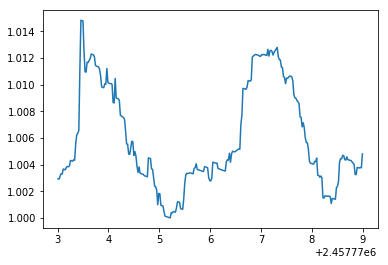

In [354]:
k2_time, k2_flux, k2_err = np.loadtxt('../libra/data/trappist1/trappist_rotation.txt', unpack=True)
k2_flux /= np.percentile(k2_flux, 0)
# slice in time
condition = (k2_time > 2457773) & (k2_time < 2457779)
k2_time, k2_flux, k2_err= k2_time[condition], k2_flux[condition], k2_err[condition]

plt.plot(k2_time, k2_flux)

std:  0.00118321694268
270 270


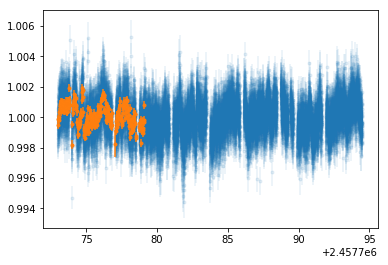

In [355]:
spitzer_time, spitzer_flux, spitzer_err, _ = np.loadtxt('../libra/data/T1_Spitzer.txt', 
                                              unpack=True, delimiter=',')
spitzer_time += k2_time.min() - spitzer_time[0]
spitzer_flux += 1

spitzer_std = np.std(spitzer_flux)
print('std: ', spitzer_std)

from scipy.stats import binned_statistic

#bins = np.arange(spitzer_time.min(), spitzer_time.max(), 1/24)
bins = np.arange(k2_time.min(), k2_time.max()+6*(k2_time[1]-k2_time[0]), k2_time[1]-k2_time[0])
bs1 = binned_statistic(spitzer_time, spitzer_flux, statistic='mean', bins=bins)
bs2 = binned_statistic(spitzer_time, spitzer_flux, statistic='std', bins=bins)
bs3 = binned_statistic(spitzer_time, spitzer_err, statistic='mean', bins=bins)
bs4 = binned_statistic(spitzer_time, spitzer_err, statistic='count', bins=bins)

plt.errorbar(spitzer_time, spitzer_flux, spitzer_err, fmt='.', alpha=0.1)

bincenters = 0.5 * (bins[1:] + bins[:-1])

spitzer_times = bincenters
spitzer_fluxes = bs1.statistic
spitzer_errors = bs3.statistic / np.sqrt(bs4.statistic)

spitzer_times = spitzer_times[~np.isnan(spitzer_fluxes)]
spitzer_errors = spitzer_errors[~np.isnan(spitzer_fluxes)]
spitzer_fluxes = spitzer_fluxes[~np.isnan(spitzer_fluxes)]

plt.errorbar(spitzer_times, spitzer_fluxes, spitzer_errors, fmt='.', zorder=100)
print(len(spitzer_times), len(k2_time))

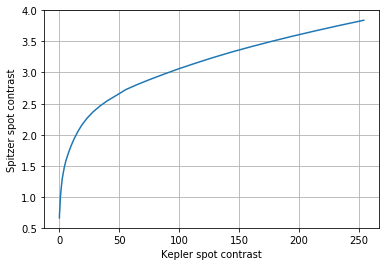

In [356]:
kepler_contrast, spitzer_contrast = np.loadtxt('kepler_to_spitzer_contrast.txt', unpack=True)

def kepler_to_spitzer_contrast_interp(contrast):
    return np.interp(contrast, kepler_contrast, spitzer_contrast)

plt.plot(kepler_contrast, spitzer_contrast)
plt.grid()
plt.xlabel('Kepler spot contrast')
plt.ylabel('Spitzer spot contrast')
plt.savefig('kepler_spitzer_contrasts.png', dpi=200)

In [357]:
# plt.plot(kepler_contrast_range, spitzer_contrast_range)
# contrast_p = np.polyfit(kepler_contrast_range, spitzer_contrast_range, 10)

# contrast_p = np.array([ -2.86673787e+00,   3.04324483e+01,  -1.39102663e+02,
#                          3.58168264e+02,  -5.70729646e+02,   5.82371946e+02,
#                         -3.80959509e+02,   1.55908866e+02,  -3.81530016e+01,
#                          5.54607524e+00,   3.85779028e-01])

# def kepler_to_spitzer_contrast_interp(kepler_contrast):
#     return np.polyval(contrast_p, kepler_contrast)

# plt.plot(kepler_contrast_range, np.polyval(contrast_p, kepler_contrast_range), ls='--')
# plt.xlabel('kepler contrast')
# plt.ylabel('spitzer contrast')
# plt.grid()

In [358]:
def model(p, kepler_time):
    lat0, lon0, rad0, lat1, lon1, rad1, lat2, lon2, rad2, kepler_contrast, kep_offset = p
    
    # Kepler
    spots = [Spot.from_latlon(lat0, lon0, rad0, contrast=kepler_contrast), 
             Spot.from_latlon(lat1, lon1, rad1, contrast=kepler_contrast), 
             Spot.from_latlon(lat2, lon2, rad2, contrast=kepler_contrast)]

    kepler_star = Star(spots=spots, rotation_period=3.3*u.day)
    kepler_model_flux = kepler_star.flux(kepler_time)
    norm_factor = np.min(kepler_model_flux)
    kepler_model_flux /= norm_factor
    kepler_model_flux += kep_offset
    
    # Spitzer
    spitzer_contrast = kepler_to_spitzer_contrast_interp(kepler_contrast)
    #print(spitzer_contrast / kepler_contrast)
    spitzer_model_flux = (kepler_model_flux - 1) * spitzer_contrast / kepler_contrast + 1
    spitzer_model_flux /= np.median(spitzer_model_flux)
    
    return kepler_model_flux, spitzer_model_flux

def chi2(p, kepler_time):
    kepler_model_flux, model_spitzer_flux = model(p, kepler_time)
    k2_chi2 = np.sum((kepler_model_flux - k2_flux)**2 / (2*k2_err)**2)
    spitzer_chi2 = np.sum((model_spitzer_flux - spitzer_fluxes)**2 / (2*spitzer_errors)**2)
    return k2_chi2 + spitzer_chi2

def lnprior(p):
    lat0, lon0, rad0, lat1, lon1, rad1, lat2, lon2, rad2, contrast, kep_offset = p
    lats = np.array([lat0, lat1, lat2])
    lons = np.array([lon0, lon1, lon2])
    rads = np.array([rad0, rad1, rad2])
    
    if np.any(lats < -90) or np.any(lats > 90):
        return -np.inf
    if np.any(lons < 0) or np.any(lons > 360):
        return -np.inf
    if np.any(rads < 0) or np.any(rads > 1):
        return -np.inf
    if not (300 < lon0 < 360 and 30 < lon1 < 70 and 190 < lon2 < 280):
#     if not (110 < lon0 < 170 and 200 < lon1 < 300 and 0 < lon2 < 80): # dark
        return -np.inf
    if not (1 < contrast < 100):
        return -np.inf
    if not (-1 < kep_offset < 1):
        return -np.inf
    return 0

def lnprob(p, kepler_time):
    lp = lnprior(p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + -0.5*chi2(p, kepler_time)

initp = np.array([0, 330, 0.02, 
                  0,  50, 0.008, 
                  0, 210, 0.008, 20, 0])
ndim, nwalkers = 11, 40
pos = [initp + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

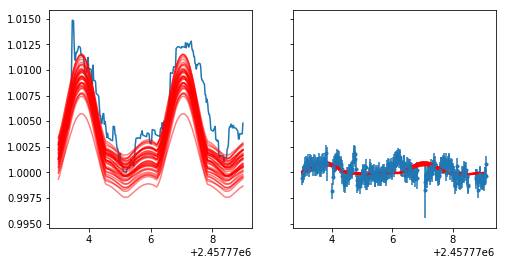

In [359]:

# # dark spots
# initp = np.array([  0.00000000e+00,   145,  0.2,
#                     0.00000000e+00,   225,  0.2,
#                     0.00000000e+00,   70,   0.2, 
#                     0.9])

# bright spots
# initp = np.array([0, 330, 0.4, 
#                   0,  50, 0.2, 
#                   0, 210, 0.2, 1.05])
# initp = np.array([0, 330, 0.07, 
#                   0,  50, 0.04, 
#                   0, 210, 0.04, 3])
initp = np.array([0, 330, 0.02, 
                  0,  50, 0.008, 
                  0, 210, 0.008, 20, 0])
pos = [initp + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
ax[0].plot(k2_time, k2_flux)
ax[1].errorbar(spitzer_times, spitzer_fluxes, spitzer_errors*3, fmt='.')
for p in pos:
    model_k2_fluxes, model_spitzer_flux = model(p, k2_time)
    ax[0].plot(k2_time, model_k2_fluxes, color='r', alpha=0.5)
    ax[1].plot(k2_time, model_spitzer_flux, color='r', alpha=0.5)
    #print(model_spitzer_std, spitzer_std)

In [360]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(k2_time, ), 
                                threads=8)
sampler.run_mcmc(pos, 5000);

In [361]:
n_burnin = 2000
samples = sampler.chain[:, n_burnin:, :].reshape((-1, ndim))
# samples = sampler.flatchain

In [362]:
np.savetxt('posteriors_bright_spot.txt', samples)

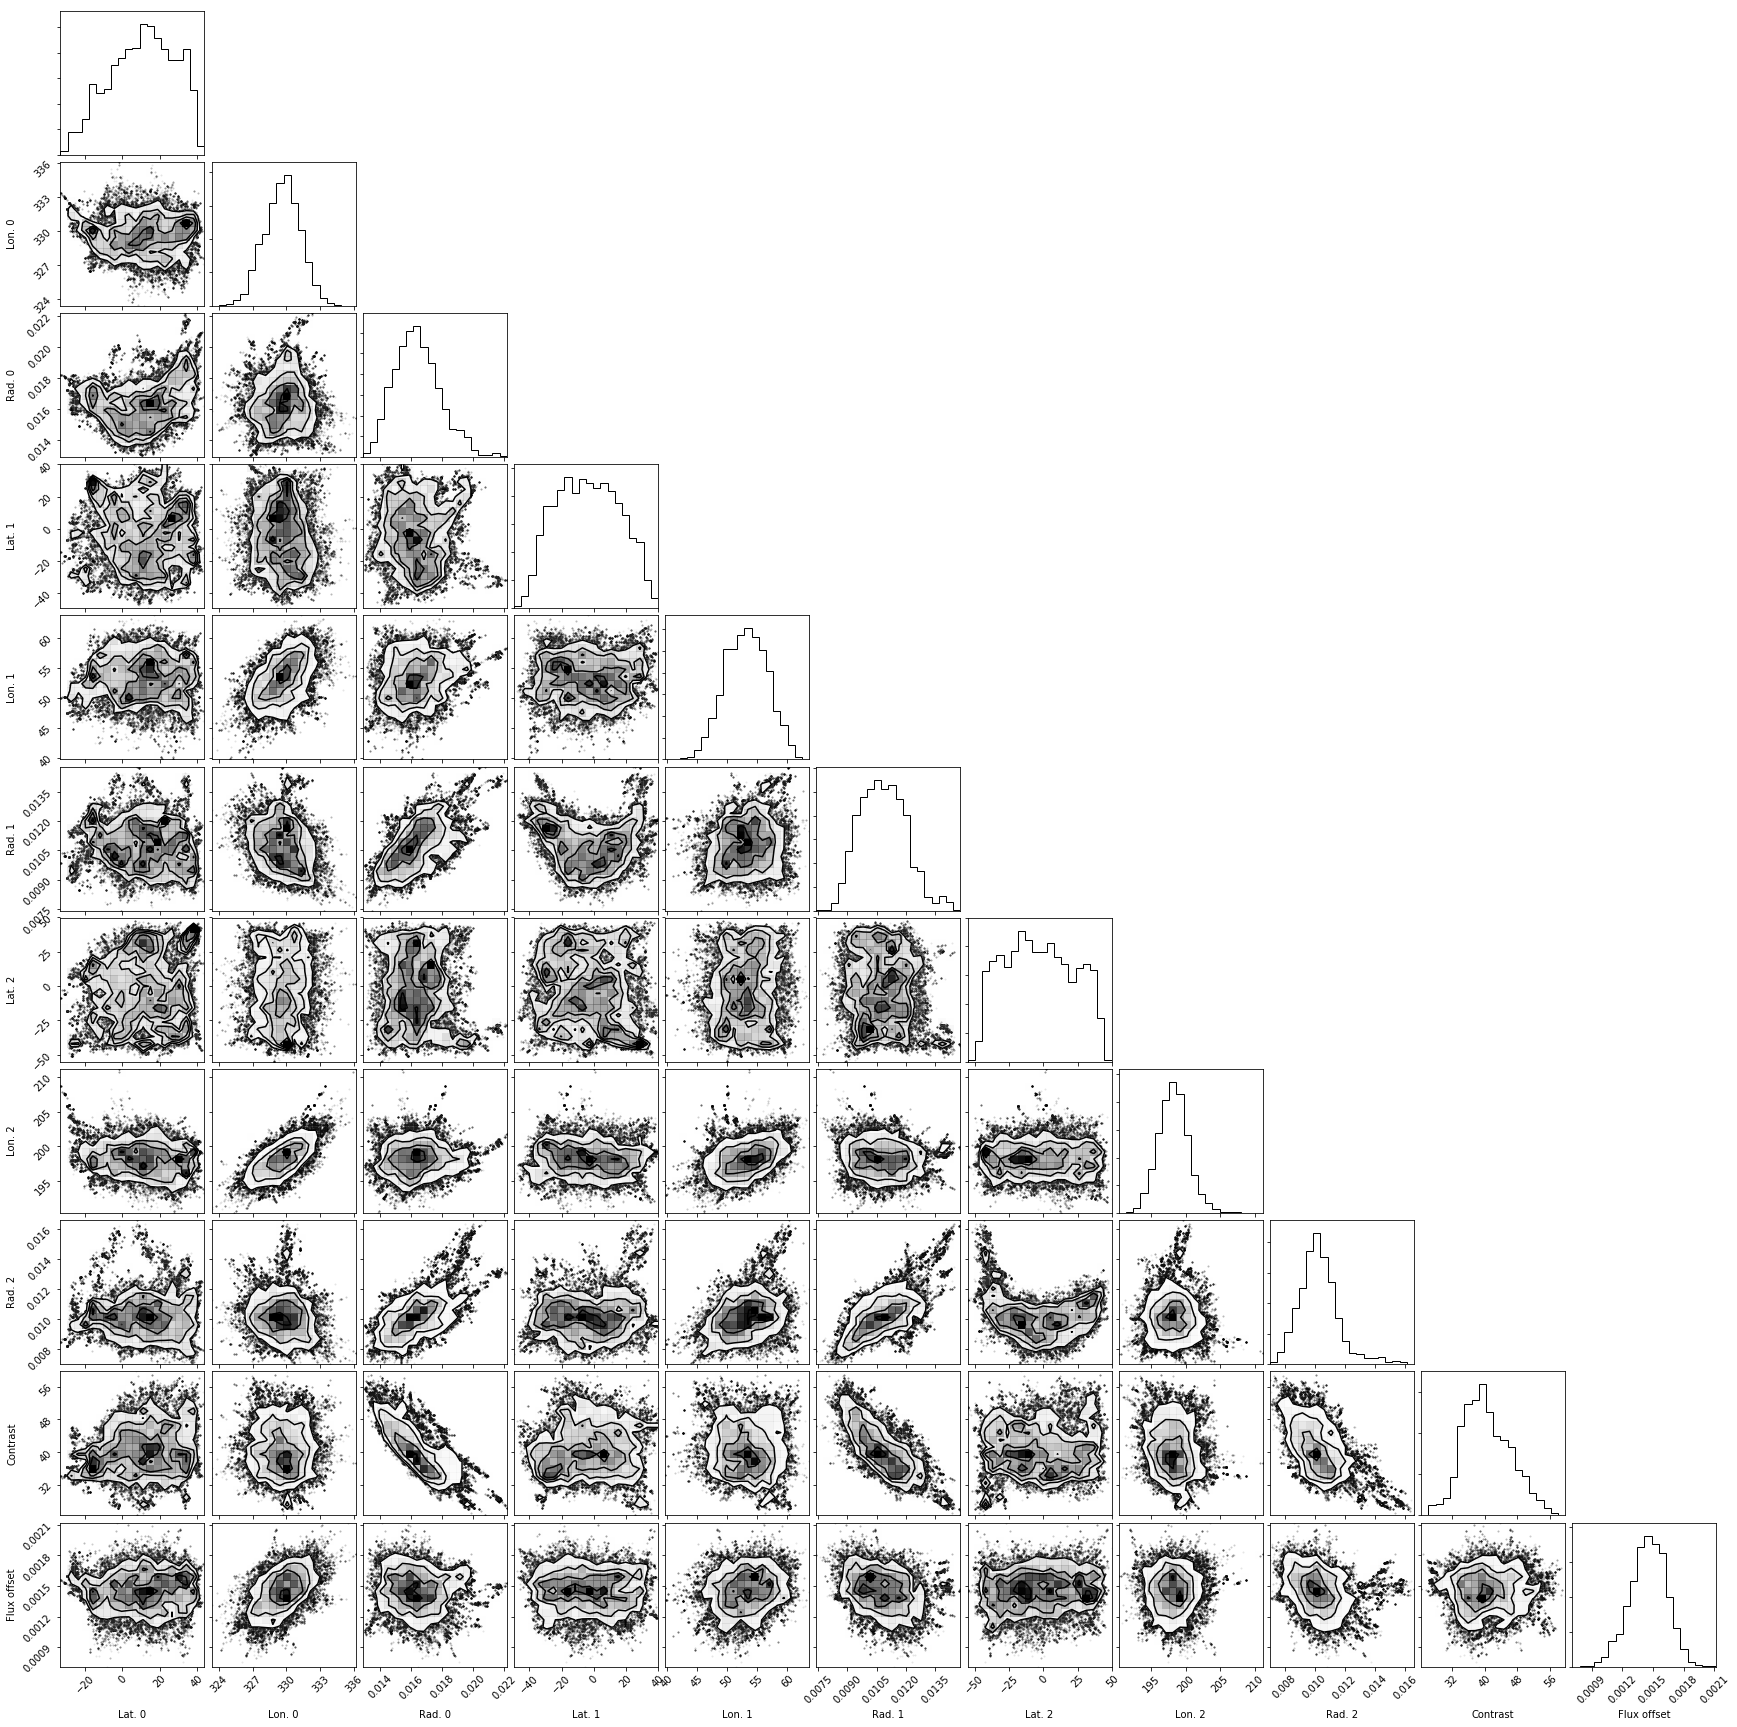

In [363]:
labels = ['Lat. 0', 'Lon. 0', 'Rad. 0', 'Lat. 1', 'Lon. 1', 'Rad. 1', 
          'Lat. 2', 'Lon. 2', 'Rad. 2', 'Contrast', 'Flux offset']
from corner import corner

corner(samples, labels=labels)

plt.savefig('corner_bright_spitzer.png', bbox_inches='tight', dpi=250)
plt.savefig('corner_bright_spitzer.pdf', bbox_inches='tight')
plt.show()

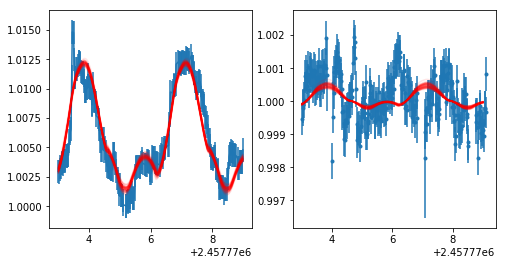

In [364]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].errorbar(k2_time, k2_flux, 2*k2_err)
ax[1].errorbar(spitzer_times, spitzer_fluxes, spitzer_errors*2, fmt='.')
for p in samples[np.random.randint(0, samples.shape[0], 50), :]:
    model_k2_fluxes, model_spitzer_flux = model(p, k2_time)
    ax[0].plot(k2_time, model_k2_fluxes, alpha=0.1, color='r', zorder=10)
    ax[1].plot(k2_time, model_spitzer_flux, alpha=0.1, color='r', zorder=10)
    #print(model_spitzer_std, spitzer_std)

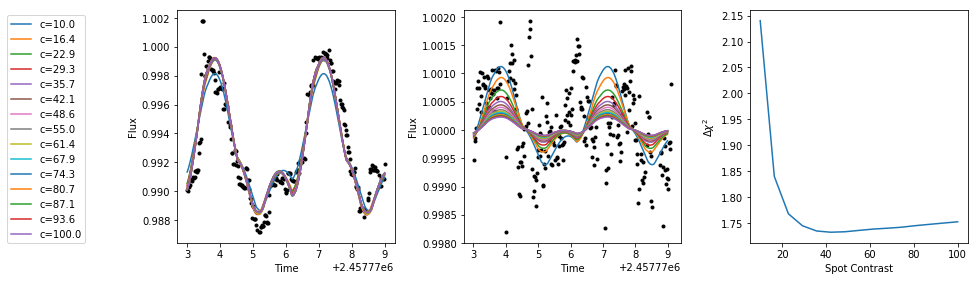

In [322]:
from scipy.optimize import fmin_tnc

def model_d(p, kepler_time, kepler_contrast):
    lat0, lon0, rad0, lat1, lon1, rad1, lat2, lon2, rad2, kep_offset = p
    
    # Kepler
    spots = [Spot.from_latlon(lat0, lon0, rad0, contrast=kepler_contrast), 
             Spot.from_latlon(lat1, lon1, rad1, contrast=kepler_contrast), 
             Spot.from_latlon(lat2, lon2, rad2, contrast=kepler_contrast)]

    kepler_star = Star(spots=spots, rotation_period=3.3*u.day)
    kepler_model_flux = kepler_star.flux(kepler_time)
    norm_factor = np.max(kepler_model_flux)
    kepler_model_flux /= norm_factor
    kepler_model_flux += kep_offset
    
    # Spitzer
    spitzer_contrast = kepler_to_spitzer_contrast_interp(kepler_contrast)
    #print(spitzer_contrast / kepler_contrast)
    spitzer_model_flux = (kepler_model_flux - 1) * spitzer_contrast / kepler_contrast + 1
    spitzer_model_flux /= np.median(spitzer_model_flux)
    
    return kepler_model_flux, spitzer_model_flux

def chi2_d(p, kepler_time, kepler_contrast):
    kepler_model_flux, model_spitzer_flux = model_d(p, kepler_time, kepler_contrast)
    k2_chi2 = np.sum((kepler_model_flux - k2_flux)**2 / (2*k2_err)**2)
    spitzer_chi2 = np.sum((model_spitzer_flux - spitzer_fluxes)**2 / (2*spitzer_errors)**2)
    return k2_chi2 + spitzer_chi2

initp = np.array([0, 330, 0.02, 
                  0,  50, 0.008, 
                  0, 210, 0.008, 0])

bounds = [[-89, 89], [0, 360], [0, 1],
          [-89, 89], [0, 360], [0, 1],
          [-89, 89], [0, 360], [0, 1], [-1, 1]]

reduced_chi2 = []
contrasts = np.linspace(10, 100, 15)
results = []
dof = 9

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(k2_time, k2_flux, '.k')

ax[1].plot(spitzer_times, spitzer_fluxes, '.k')


from astropy.utils.console import ProgressBar

with ProgressBar(len(contrasts), ipython_widget=True) as bar:
    median_radius = []

    for i, contrast in enumerate(contrasts):
        if i > 0:
            initp = results[-1] #+ 0.01 * np.random.randn()
        result = fmin_tnc(chi2_d, initp, args=(k2_time, contrast), bounds=bounds, disp=True,
                  approx_grad=True)[0]
        k_model, s_model = model_d(result, k2_time, contrast)
        red_chi2 = ((np.sum((k_model - k2_flux)**2 / (2*k2_err)**2) + 
                     np.sum((s_model - spitzer_fluxes)**2 / (2*spitzer_errors)**2)) / 
                    (2*len(k2_time) - dof))
        reduced_chi2.append(red_chi2)
        results.append(result)
        median_radius.append(np.median(result[2::3]))
        bar.update()

        ax[0].plot(k2_time, k_model, label="c={0:.1f}".format(contrast))
        ax[1].plot(k2_time, s_model)


        #ax[1].plot(contrasts, median_radius)

ax[0].legend(bbox_to_anchor=(-1.4, 0, 1., 1))

ax[2].plot(contrasts, reduced_chi2)

ax[0].set(xlabel='Time', ylabel='Flux')

ax[1].set(xlabel='Time', ylabel='Flux')


ax[2].set(xlabel='Spot Contrast', ylabel='$\Delta \chi^2$')
fig.tight_layout()
fig.savefig('degeneracy_bright_spot.pdf', bbox_inches='tight')
plt.show()

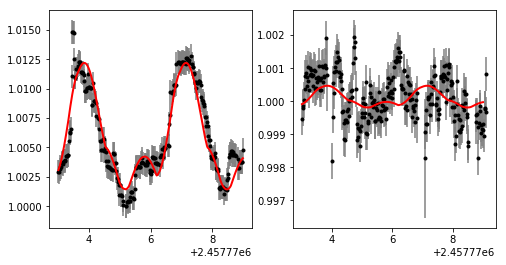

In [449]:
best_params = sampler.flatchain[np.argmax(sampler.flatlnprobability), :]
best_model_k2, best_model_sp = model(best_params, k2_time)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].errorbar(k2_time, k2_flux, 2*k2_err, fmt='.', color='k', ecolor='gray')
ax[1].errorbar(spitzer_times, spitzer_fluxes, spitzer_errors*2, fmt='.', color='k', ecolor='gray')

ax[0].plot(k2_time, best_model_k2, color='r', zorder=10, lw=2)
ax[1].plot(k2_time, best_model_sp, color='r', zorder=10, lw=2)

In [450]:
extended_model_k2, extended_model_sp = model(best_params, spitzer_time)



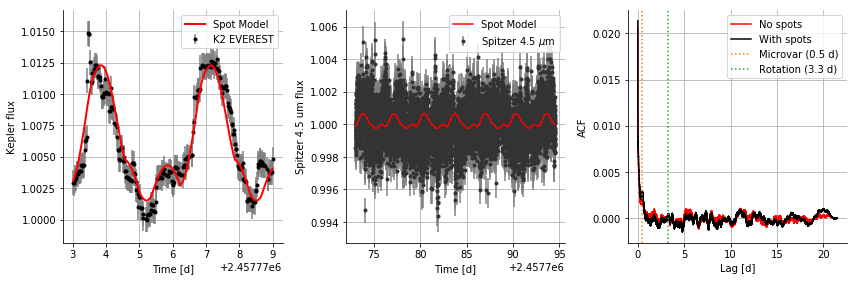

In [370]:
from interpacf import interpolated_acf, dominant_period

lag, acf = interpolated_acf(spitzer_time, spitzer_flux + (extended_model_sp - 1) - 1)

lag_nospots, acf_nospots = interpolated_acf(spitzer_time, spitzer_flux - 1)

best_period = dominant_period(lag, acf)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].errorbar(k2_time, k2_flux, 2*k2_err, fmt='.', color='k', ecolor='gray', label='K2 EVEREST')
ax[0].plot(k2_time, best_model_k2, color='r', zorder=10, lw=2, label='Spot Model')
ax[0].set(xlabel='Time [d]', ylabel='Kepler flux')
ax[0].legend()

ax[1].errorbar(spitzer_time, spitzer_flux, spitzer_err, label='Spitzer 4.5 $\mu$m', fmt='.', color='#333333', ecolor='gray')
ax[1].plot(spitzer_time, extended_model_sp, label='Spot Model', color='r', zorder=10)
ax[1].legend()

ax[2].plot(lag_nospots, acf_nospots, color='r', label='No spots')
ax[2].plot(lag, acf, color='k', label='With spots')

ax[2].set_xlabel('Lag [d]')
ax[2].set_ylabel('ACF')
ax[1].set(xlabel='Time [d]', ylabel='Spitzer 4.5 um flux')
ax[2].axvline(0.5, ls=':', color='C1', label='Microvar (0.5 d)')
ax[2].axvline(3.3, ls=':', color='C2', label='Rotation (3.3 d)')
ax[2].legend()

for axis in ax: 
    axis.grid()
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)

fig.tight_layout()
fig.savefig('best_bright_spot_model.png', bbox_inches='tight', dpi=250)
fig.savefig('best_bright_spot_model.pdf', bbox_inches='tight')

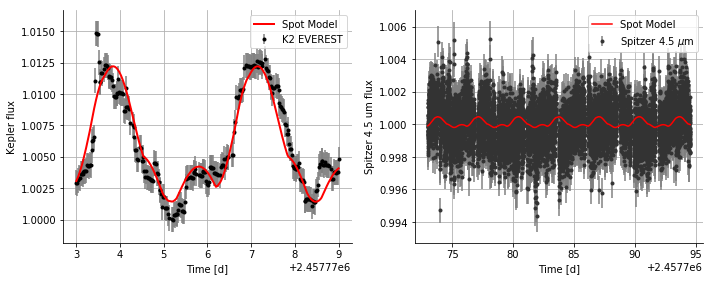

In [451]:
from interpacf import interpolated_acf, dominant_period

lag, acf = interpolated_acf(spitzer_time, spitzer_flux + (extended_model_sp - 1) - 1)

lag_nospots, acf_nospots = interpolated_acf(spitzer_time, spitzer_flux - 1)

best_period = dominant_period(lag, acf)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].errorbar(k2_time, k2_flux, 2*k2_err, fmt='.', color='k', ecolor='gray', label='K2 EVEREST')
ax[0].plot(k2_time, best_model_k2, color='r', zorder=10, lw=2, label='Spot Model')
ax[0].set(xlabel='Time [d]', ylabel='Kepler flux')
ax[0].legend()

ax[1].errorbar(spitzer_time, spitzer_flux, spitzer_err, label='Spitzer 4.5 $\mu$m', fmt='.', color='#333333', ecolor='gray')
ax[1].plot(spitzer_time, extended_model_sp, label='Spot Model', color='r', zorder=10)
ax[1].legend()
ax[1].set(xlabel='Time [d]', ylabel='Spitzer 4.5 um flux')

for axis in ax: 
    axis.grid()
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)

fig.tight_layout()
fig.savefig('best_bright_spot_model.png', bbox_inches='tight', dpi=250)
fig.savefig('best_bright_spot_model.pdf', bbox_inches='tight')

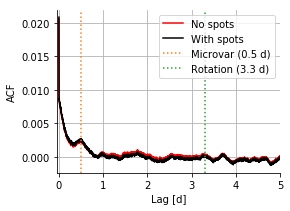

In [452]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(lag_nospots, acf_nospots, color='r', label='No spots')
ax.plot(lag, acf, color='k', label='With spots')

ax.set_xlabel('Lag [d]')
ax.set_ylabel('ACF')
ax.axvline(0.5, ls=':', color='C1', label='Microvar (0.5 d)')
ax.axvline(3.3, ls=':', color='C2', label='Rotation (3.3 d)')
ax.legend()
ax.grid()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim([-0.05, 5])
fig.savefig('acf_sanity.pdf', bbox_inches='tight')

Spot radii: 

In [383]:
np.median(samples[:, 2::3], axis=0), np.std(samples[:, 2::3], axis=0)

(array([ 0.01632128,  0.01076724,  0.0101565 ]),
 array([ 0.00147665,  0.00118   ,  0.00135566]))

Spot contrast in the kepler band

In [384]:
np.median(samples[:, -2]), np.std(samples[:, -2])

(39.919990681268786, 5.7863607406988304)

spot contrast in the spitzer band

In [386]:
kepler_to_spitzer_contrast_interp(np.median(samples[:, -2]) + np.std(samples[:, -2]))

2.609787494675178

Total spot coverage

In [389]:
np.sum(np.pi * np.median(samples[:, 2::3], axis=0)**2 / (4 * np.pi))

0.00012136801623011295

In [448]:
typical_spot_radius = np.median(np.median(samples[:, 2::3], axis=0))
typical_spot_contrast_kepler = np.median(samples[:, -2])
typical_spot_contrast_spitzer = kepler_to_spitzer_contrast_interp(np.median(samples[:, -2]))


print(typical_spot_radius, typical_spot_contrast_kepler)

contamination_kepler = 1 + typical_spot_contrast_kepler * typical_spot_radius**2

contamination_spitzer = 1 + typical_spot_contrast_spitzer * typical_spot_radius**2

contamination_kepler, contamination_spitzer

0.0107672386509 39.9199906813


(1.0046280613719802, 1.0002947711025514)

In [399]:
from libra import trappist1

rps = [trappist1(p).rp for p in list('bcdefgh')]

In [445]:
from astropy.constants import R_sun, R_earth

old_depths = np.array([[0.7266, 0.0088], [0.687, 0.010], [0.367, 0.017], [0.519, 0.026], 
                       [0.673, 0.023], [0.782, 0.027], [0.352, 0.0326]]) / 100
R_star = 0.117 * R_sun
sigma_R_star = 0.0036 #* R_sun
new_depths = old_depths * contamination_kepler

u1, u2 = trappist1('b').u
ld_constant = (1 - u1/3 - u2/6)

new_radii = ((np.sqrt(new_depths[:, 0] * ld_constant) * R_star / R_earth).decompose()).value
new_radii_errors = ((np.sqrt((0.5 / np.sqrt(new_depths[:, 0] * ld_constant) * new_depths[:, 1])**2 + 
                           (np.sqrt(new_depths[:, 0] * ld_constant) * sigma_R_star)**2 )) * R_star/R_earth).value

In [446]:
new_radii, new_radii_errors

(array([ 1.0378414 ,  1.00916379,  0.73759222,  0.87713607,  0.99882827,
         1.07668006,  0.72236155]),
 array([ 0.00787901,  0.00888358,  0.01904168,  0.02445489,  0.01917856,
         0.0208786 ,  0.03701229]))